In [12]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.stats import entropy

In [24]:
df = pd.read_csv("features_china.csv")

cols_to_drop = [
    "n_tokens",
    "n_sentences",
    "num_person",
    "num_org",
    "num_gpe",
    "hedge_density",
    "assertive_density",
    "sentiment_polarity",
    "sentiment_intensity",
    "has_china"
]

df = df.drop(columns=cols_to_drop)

df = df.iloc[:, 1:]

In [25]:
df

,source,packageId,title,date,text,clean_text,china_mentions
0,cpd,DCPD-200900019,Remarks on Energy,2009-01-26,"Administration of Barack H. Obama, 2009\nRemar...",Good morning. Before I begin today's announcem...,1
1,cpd,DCPD-200900072,Remarks on Economic Stabilization and a Questi...,2009-02-09,"Administration of Barack H. Obama, 2009\nRemar...",The President. Thank you. Thank you so much. W...,1
2,cpd,DCPD-200900074,Remarks on Economic Stabilization and a Questi...,2009-02-10,"Administration of Barack H. Obama, 2009\nRemar...","The President. All right, everybody. Thank you...",2
3,cpd,DCPD-200900095,Interview With Peter Mansbridge of Canadian Br...,2009-02-17,"Administration of Barack H. Obama, 2009\nInter...","Trade Mr. Mansbridge. Mr. President, thank you...",4
4,cpd,DCPD-200900096,The President's News Conference With Prime Min...,2009-02-19,"Administration of Barack H. Obama, 2009\nThe P...","President Obama. Hello, good afternoon. Prime ...",1
...,...,...,...,...,...,...,...
2454,cpd,DCPD-202500955,Remarks at a Document Signing Ceremony and an ...,2025-09-25,DCPD202500955\nAdministration of Donald J. Tru...,DCPD202500955 Administration of Donald J. Trum...,19
2455,cpd,DCPD-202500973,Remarks on Signing an Executive Order on Unloc...,2025-09-30,DCPD202500973\nAdministration of Donald J. Tru...,DCPD202500973 Administration of Donald J. Trum...,2
2456,cpd,DCPD-202500970,"Remarks to the Department of War in Quantico, ...",2025-09-30,DCPD202500970\nAdministration of Donald J. Tru...,DCPD202500970 Administration of Donald J. Trum...,3
2457,cpd,DCPD-2025DIGEST,Digest of Other White House Announcements,2025-11-21,"Digest\nAdministration of Donald J. Trump, 202...","Digest Administration of Donald J. Trump, 2025...",32


In [13]:
# Extract probabilities from FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def extract_full_sentiment(text):
    # FinBERT probabilities
    inputs = tokenizer(text[:512], return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
    
    prob_pos = probs[0].item()
    prob_neg = probs[1].item()
    prob_neu = probs[2].item()
    
    # Continuous score
    sentiment_score = prob_pos - prob_neg
    
    # Certainty
    ent = entropy([prob_pos, prob_neu, prob_neg], base=2)
    certainty = 1 - (ent / 1.585)
    
    # Adjusted score
    sentiment_adjusted = sentiment_score * certainty
    
    return {
        'sentiment_score': sentiment_score,
        'sentiment_certainty': certainty,
        'sentiment_adjusted': sentiment_adjusted,
        'prob_positive': prob_pos,
        'prob_negative': prob_neg,
        'prob_neutral': prob_neu
    }

In [14]:
# Add emotion analysis
emotion_pipeline = pipeline("text-classification", 
                           model="j-hartmann/emotion-english-distilroberta-base",
                           top_k=None)

def extract_emotions(text):
    result = emotion_pipeline(text[:512])[0]
    emotions = {item['label']: item['score'] for item in result}
    
    negative_intensity = sum([
        emotions.get('anger', 0),
        emotions.get('fear', 0),
        emotions.get('sadness', 0),
        emotions.get('disgust', 0)
    ])
    
    return {
        'anger_score': emotions.get('anger', 0),
        'fear_score': emotions.get('fear', 0),
        'negative_intensity': negative_intensity
    }


c:\Users\ziyus\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ziyus\.cache\huggingface\hub\models--j-hartmann--emotion-english-distilroberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is no

In [15]:
# Apply to all texts
df['finbert_features'] = df['clean_text'].apply(extract_full_sentiment)
df['emotion_features'] = df['clean_text'].apply(extract_emotions)

df_finbert = pd.DataFrame(df['finbert_features'].tolist())
df_emotion = pd.DataFrame(df['emotion_features'].tolist())

In [18]:
df_finbert.to_csv("finbert_results.csv")

In [19]:
df_emotion.to_csv("emotion_results.csv")

In [26]:
df

,source,packageId,title,date,text,clean_text,china_mentions
0,cpd,DCPD-200900019,Remarks on Energy,2009-01-26,"Administration of Barack H. Obama, 2009\nRemar...",Good morning. Before I begin today's announcem...,1
1,cpd,DCPD-200900072,Remarks on Economic Stabilization and a Questi...,2009-02-09,"Administration of Barack H. Obama, 2009\nRemar...",The President. Thank you. Thank you so much. W...,1
2,cpd,DCPD-200900074,Remarks on Economic Stabilization and a Questi...,2009-02-10,"Administration of Barack H. Obama, 2009\nRemar...","The President. All right, everybody. Thank you...",2
3,cpd,DCPD-200900095,Interview With Peter Mansbridge of Canadian Br...,2009-02-17,"Administration of Barack H. Obama, 2009\nInter...","Trade Mr. Mansbridge. Mr. President, thank you...",4
4,cpd,DCPD-200900096,The President's News Conference With Prime Min...,2009-02-19,"Administration of Barack H. Obama, 2009\nThe P...","President Obama. Hello, good afternoon. Prime ...",1
...,...,...,...,...,...,...,...
2454,cpd,DCPD-202500955,Remarks at a Document Signing Ceremony and an ...,2025-09-25,DCPD202500955\nAdministration of Donald J. Tru...,DCPD202500955 Administration of Donald J. Trum...,19
2455,cpd,DCPD-202500973,Remarks on Signing an Executive Order on Unloc...,2025-09-30,DCPD202500973\nAdministration of Donald J. Tru...,DCPD202500973 Administration of Donald J. Trum...,2
2456,cpd,DCPD-202500970,"Remarks to the Department of War in Quantico, ...",2025-09-30,DCPD202500970\nAdministration of Donald J. Tru...,DCPD202500970 Administration of Donald J. Trum...,3
2457,cpd,DCPD-2025DIGEST,Digest of Other White House Announcements,2025-11-21,"Digest\nAdministration of Donald J. Trump, 202...","Digest Administration of Donald J. Trump, 2025...",32


In [ ]:
df_sentiment_features = pd.concat([df, df_finbert, df_emotion], axis=1)


In [30]:
sentiment_features = df_sentiment_features.drop(columns=['source', 'packageId', 'title', 'text', 'clean_text'])

sentiment_features

,date,china_mentions,sentiment_score,sentiment_certainty,sentiment_adjusted,prob_positive,prob_negative,prob_neutral,anger_score,fear_score,negative_intensity
0,2009-01-26,1,-0.946313,0.814099,-0.770392,0.009396,0.955709,0.034895,0.024362,0.026520,0.759571
1,2009-02-09,1,0.200677,0.420835,0.084452,0.223927,0.023250,0.752823,0.003028,0.001960,0.014875
2,2009-02-10,2,0.269753,0.362504,0.097787,0.291435,0.021682,0.686883,0.006586,0.002043,0.022615
3,2009-02-17,4,0.071481,0.481345,0.034407,0.123202,0.051721,0.825076,0.020521,0.052608,0.086134
4,2009-02-19,1,0.741566,0.448086,0.332285,0.753566,0.012001,0.234433,0.001366,0.000778,0.007368
...,...,...,...,...,...,...,...,...,...,...,...
2454,2025-09-25,19,0.502010,0.189444,0.095103,0.590658,0.088647,0.320695,0.071809,0.089504,0.756406
2455,2025-09-30,2,0.724505,0.429930,0.311487,0.736930,0.012425,0.250645,0.002657,0.022556,0.029278
2456,2025-09-30,3,-0.035800,0.597822,-0.021402,0.041583,0.077383,0.881034,0.064028,0.007074,0.136246
2457,2025-11-21,32,-0.012629,0.778717,-0.009834,0.020274,0.032903,0.946823,0.006863,0.017008,0.058530


In [31]:
sentiment_features.to_csv("sentiment_features.csv")

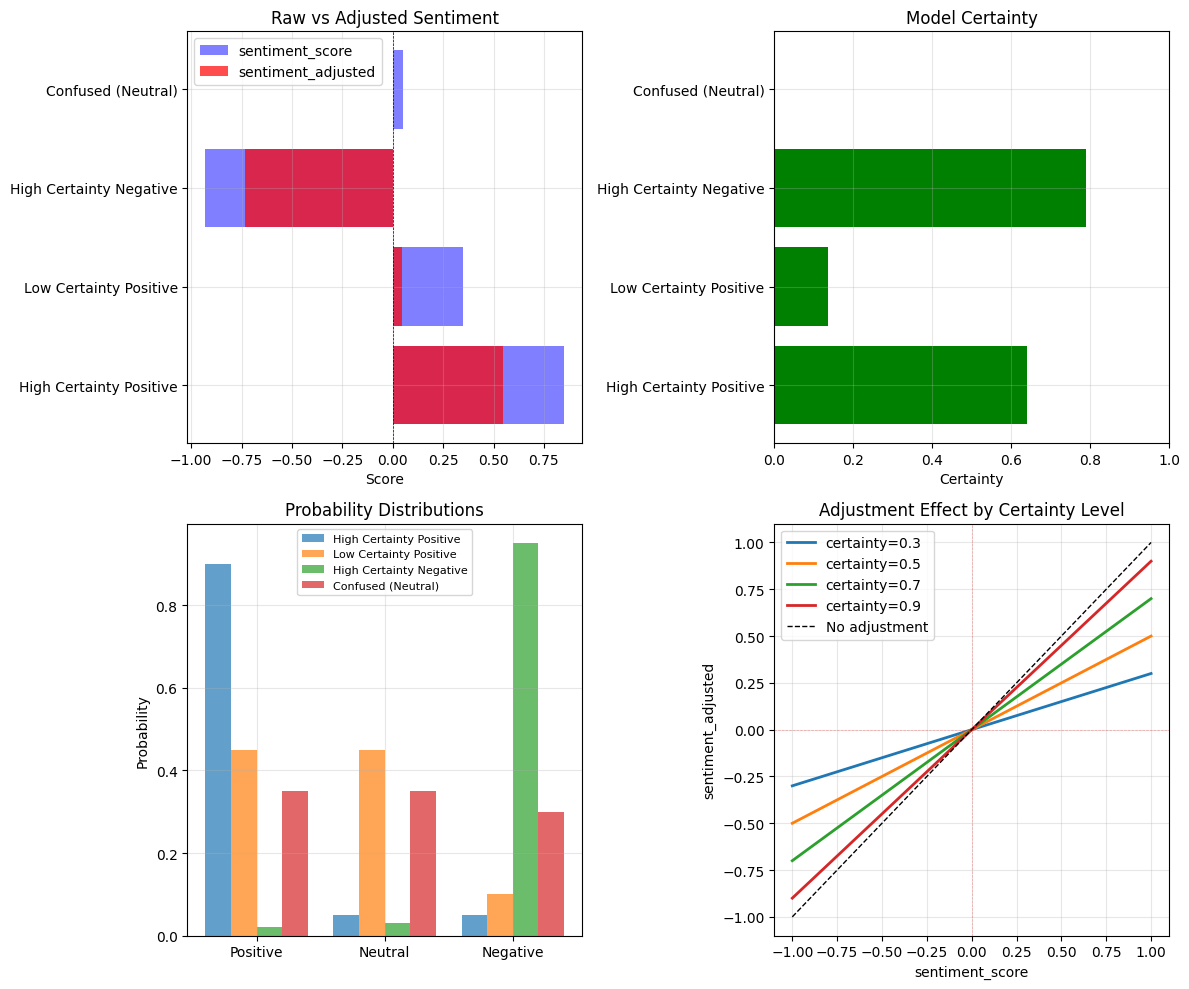

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Simulate different scenarios
scenarios = [
    {"name": "High Certainty Positive", "probs": [0.9, 0.05, 0.05]},
    {"name": "Low Certainty Positive", "probs": [0.45, 0.45, 0.1]},
    {"name": "High Certainty Negative", "probs": [0.02, 0.03, 0.95]},
    {"name": "Confused (Neutral)", "probs": [0.35, 0.35, 0.30]},
]

results = []
for scenario in scenarios:
    probs = scenario['probs']
    sentiment_score = probs[0] - probs[2]
    H = entropy(probs, base=2)
    certainty = 1 - (H / 1.585)
    sentiment_adjusted = sentiment_score * certainty
    
    results.append({
        'name': scenario['name'],
        'sentiment_score': sentiment_score,
        'certainty': certainty,
        'sentiment_adjusted': sentiment_adjusted,
        'probs': probs
    })

# Plot 1: Compare sentiment_score vs sentiment_adjusted
axes[0, 0].barh(range(len(results)), [r['sentiment_score'] for r in results], 
               alpha=0.5, label='sentiment_score', color='blue')
axes[0, 0].barh(range(len(results)), [r['sentiment_adjusted'] for r in results],
               alpha=0.7, label='sentiment_adjusted', color='red')
axes[0, 0].set_yticks(range(len(results)))
axes[0, 0].set_yticklabels([r['name'] for r in results])
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=0.5)
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_title('Raw vs Adjusted Sentiment')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Certainty levels
axes[0, 1].barh(range(len(results)), [r['certainty'] for r in results], color='green')
axes[0, 1].set_yticks(range(len(results)))
axes[0, 1].set_yticklabels([r['name'] for r in results])
axes[0, 1].set_xlabel('Certainty')
axes[0, 1].set_title('Model Certainty')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Probability distributions
for idx, result in enumerate(results):
    axes[1, 0].bar(np.arange(3) + idx*0.2, result['probs'], 
                   width=0.2, alpha=0.7, label=result['name'])
axes[1, 0].set_xticks([0.3, 1.3, 2.3])
axes[1, 0].set_xticklabels(['Positive', 'Neutral', 'Negative'])
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_title('Probability Distributions')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Adjustment factor visualization
sentiment_range = np.linspace(-1, 1, 50)
certainty_levels = [0.3, 0.5, 0.7, 0.9]

for cert in certainty_levels:
    adjusted = sentiment_range * cert
    axes[1, 1].plot(sentiment_range, adjusted, 
                   label=f'certainty={cert}', linewidth=2)

axes[1, 1].plot(sentiment_range, sentiment_range, 
               'k--', label='No adjustment', linewidth=1)
axes[1, 1].set_xlabel('sentiment_score')
axes[1, 1].set_ylabel('sentiment_adjusted')
axes[1, 1].set_title('Adjustment Effect by Certainty Level')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.savefig('sentiment_adjusted_explanation.png', dpi=300)
plt.show()


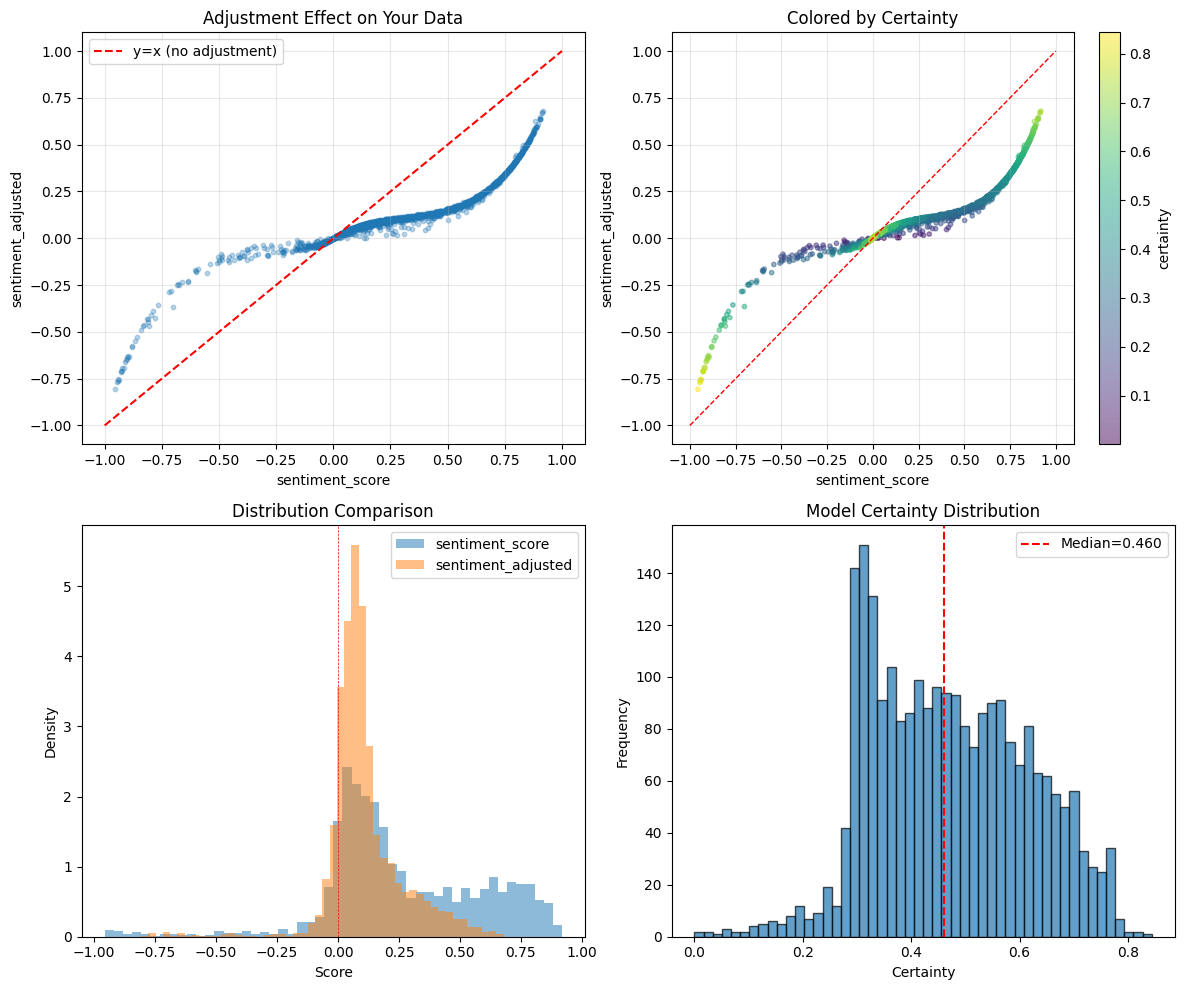


=== Summary Statistics ===
sentiment_score:     mean=0.264, std=0.322
sentiment_adjusted:  mean=0.109, std=0.157
sentiment_certainty: mean=0.469, std=0.145

Significantly adjusted: 2300 (93.5%)


In [21]:
# Load your data
df = pd.read_csv('finbert_results.csv')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Scatter - sentiment_score vs sentiment_adjusted
axes[0, 0].scatter(df['sentiment_score'], df['sentiment_adjusted'], 
                  alpha=0.3, s=10)
axes[0, 0].plot([-1, 1], [-1, 1], 'r--', label='y=x (no adjustment)')
axes[0, 0].set_xlabel('sentiment_score')
axes[0, 0].set_ylabel('sentiment_adjusted')
axes[0, 0].set_title('Adjustment Effect on Your Data')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Color by certainty
scatter = axes[0, 1].scatter(df['sentiment_score'], df['sentiment_adjusted'],
                            c=df['sentiment_certainty'], cmap='viridis',
                            alpha=0.5, s=10)
axes[0, 1].plot([-1, 1], [-1, 1], 'r--', linewidth=1)
axes[0, 1].set_xlabel('sentiment_score')
axes[0, 1].set_ylabel('sentiment_adjusted')
axes[0, 1].set_title('Colored by Certainty')
plt.colorbar(scatter, ax=axes[0, 1], label='certainty')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Distribution comparison
axes[1, 0].hist(df['sentiment_score'], bins=50, alpha=0.5, 
               label='sentiment_score', density=True)
axes[1, 0].hist(df['sentiment_adjusted'], bins=50, alpha=0.5,
               label='sentiment_adjusted', density=True)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=0.5)
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distribution Comparison')
axes[1, 0].legend()

# Plot 4: Certainty distribution
axes[1, 1].hist(df['sentiment_certainty'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df['sentiment_certainty'].median(), 
                  color='red', linestyle='--', 
                  label=f'Median={df["sentiment_certainty"].median():.3f}')
axes[1, 1].set_xlabel('Certainty')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Model Certainty Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300)
plt.show()

print("\n=== Summary Statistics ===")
print(f"sentiment_score:     mean={df['sentiment_score'].mean():.3f}, std={df['sentiment_score'].std():.3f}")
print(f"sentiment_adjusted:  mean={df['sentiment_adjusted'].mean():.3f}, std={df['sentiment_adjusted'].std():.3f}")
print(f"sentiment_certainty: mean={df['sentiment_certainty'].mean():.3f}, std={df['sentiment_certainty'].std():.3f}")

# How many get significantly adjusted?
df['adjustment_ratio'] = df['sentiment_adjusted'] / (df['sentiment_score'] + 1e-10)
significantly_adjusted = (np.abs(df['adjustment_ratio']) < 0.7) | (np.abs(df['adjustment_ratio']) > 1.3)
print(f"\nSignificantly adjusted: {significantly_adjusted.sum()} ({significantly_adjusted.sum()/len(df)*100:.1f}%)")


In [ ]:

df_final = pd.concat([df, df_finbert, df_emotion], axis=1)

# Step 4: Create temporal features
df_final = df_final.sort_values('date')
df_final['sentiment_ma7'] = df_final['sentiment_adjusted'].rolling(7).mean()
df_final['sentiment_volatility'] = df_final['sentiment_adjusted'].rolling(14).std()

print("\n=== Final Feature Summary ===")
print(df_final[['sentiment_score', 'sentiment_adjusted', 'negative_intensity']].describe())

# Save
df_final.to_csv('statements_sentiment_continuous.csv', index=False)
print("\n✅ Saved to 'statements_sentiment_continuous.csv'")


In [8]:
# Using FinBERT (for financial/policy text)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=0  # use GPU if available
)

def extract_sentiment_features(text):
    """
    Extract sentiment score from text
    Returns: dict with sentiment features
    """
    result = sentiment_analyzer(text[:512])[0]  # max 512 tokens
    
    # Map label to score
    label_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    sentiment_direction = label_map.get(result['label'], 0)
    
    # Confidence-weighted score
    sentiment_score = sentiment_direction * result['score']
    
    return {
        'sentiment_score': sentiment_score,  # [-1, 1]
        'sentiment_confidence': result['score'],  # [0, 1]
        'sentiment_label': result['label'],
        'sentiment_magnitude': abs(sentiment_score)  # intensity
    }


c:\Users\ziyus\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ziyus\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to 

In [10]:
# Apply to all texts
sentiment_features = df['clean_text'].apply(extract_sentiment_features)
sentiment_df = pd.DataFrame(sentiment_features.tolist())

sentiment_df

,sentiment_score,sentiment_confidence,sentiment_label,sentiment_magnitude
0,-0.955709,0.955709,negative,0.955709
1,0.000000,0.752823,neutral,0.000000
2,0.000000,0.686883,neutral,0.000000
3,0.000000,0.825076,neutral,0.000000
4,0.753566,0.753566,positive,0.753566
...,...,...,...,...
2454,0.590658,0.590658,positive,0.590658
2455,0.736930,0.736930,positive,0.736930
2456,0.000000,0.881034,neutral,0.000000
2457,0.000000,0.946823,neutral,0.000000


In [11]:
label_counts = sentiment_df['sentiment_label'].value_counts()
print(label_counts)

sentiment_label
neutral     1710
positive     688
negative      61
Name: count, dtype: int64


In [ ]:

# Merge with original data
df_final = pd.concat([df, sentiment_df], axis=1)